We want to estimate the effect of 401(k) eligibility on net financial assets using double machine learning as in [this paper](https://arxiv.org/abs/1608.00060) with data from [here](https://github.com/kquist/DoubleML-Python).

In [1]:
import pandas as pd
df = pd.read_stata('sipp1991.dta')

print(df.shape)
df.sample(10)

(9915, 14)


,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
8681,9948.0,24448.0,33448.0,31,58323.0,4,18,1,1,1,1,1,0,1
6377,1500.0,7000.0,14400.0,25,33630.0,1,16,0,0,0,1,1,0,0
4858,53000.0,48000.0,140550.0,53,11538.0,2,13,0,0,0,0,0,0,1
8596,249.0,-2751.0,42249.0,50,41715.0,4,12,0,1,0,1,1,0,1
487,2900.0,2700.0,6125.0,31,16527.0,1,12,0,0,0,0,0,0,0
8042,199.0,-6051.0,96649.0,45,25353.0,1,12,0,0,0,1,1,0,1
8249,2300.0,-16200.0,-15120.0,29,17880.0,2,16,0,1,1,1,0,0,0
6226,35300.0,34450.0,67450.0,31,42750.0,2,12,0,1,1,0,0,0,1
1030,1000.0,540.0,7540.0,27,24840.0,4,12,0,1,0,0,0,0,1
4991,5000.0,2600.0,93950.0,61,16056.0,5,8,0,0,0,0,0,0,1


# Estimator

We create an estimator class which does the algorithm.

The model is
\begin{align*}
Y &= T\cdot\theta + m_1(X) + R_1, &E[R_1|X, T] = 0,
\\
T &= m_2(X) + R_2, &E[R_2|X] = 0.
\end{align*}
To estimate $\theta$,
1. Split the data set about half-half into $I$ and $I^C$ for cross-fitting.
1. Fit $Y$ versus $X$ on $I$ to approximate $m_1$. Compute the residual $R_1$ on $I^C$.
1. Fit $T$ versus $X$ on $I$ to approximate $m_2$. Compute the residual $R_2$ on $I^C$.
1. Fit a linear model for $R_1$ versus $R_2$, giving an estimate $\theta_I$ for $\theta$.
1. Repeat by interchaning $I$ and $I^c$.
1. Average $\theta_I$ and $\theta_{I^c}$.

In [6]:
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')


class DoubleML():
    
    def __init__(self):
        self.LinearModel = LinearRegression()
    
    def set_model(self, M):
        self.Model = M
        return self

    def set_df(self, df):
        self.df = df
        
        # Cross-splitting
        self.df1 = df.sample(frac=0.5)
        self.df2 = df.drop(self.df1.index)
        
        return self

    def set_outcomes(self, o):
        self.outcomes = o
        return self

    def set_treatments(self, t):
        self.treatments = t
        return self

    def set_controls(self, c=None):
        
        # Assign remaining columns if controls not set
        if c is None:
            c = [
                col for col in self.df.columns
                if col not in self.outcomes
                and col not in self.treatments
            ]
        
        self.controls = c
        return self

    @staticmethod
    def get_residual(df1, df2, x, y, model):
        
        X1 = df1[x]
        Y1 = df1[y]
        
        X2 = df2[x]
        Y2 = df2[y]
        
        Y2_pred = pd.DataFrame(columns=Y2.columns, index=df2.index)
        # FIXME need to reshape after sklearn 
        Y2_pred[Y2.columns] = model.fit(X1, Y1).predict(X2).reshape(-1, len(y))
        residual = Y2 - Y2_pred
        
        return residual
        
    def estimate_cross(self, df1, df2):
        
        # Treatments vs Controls
        residual_tc = self.get_residual(
            df1, df2, self.controls, self.treatments, self.Model
        )
        
        # Outcomes vs Controls
        residual_oc = self.get_residual(
            df1, df2, self.controls, self.outcomes, self.Model
        )
        
        # Second vs First Residuals
        coef = self.LinearModel\
            .fit(residual_tc, residual_oc)\
            .coef_
        
        return pd.DataFrame(coef, columns=treatments)
    
    def estimate_once(self):
        
        coef1 = self.estimate_cross(self.df1, self.df2)
        coef2 = self.estimate_cross(self.df2, self.df1)
        
        return (coef1 + coef2)/2
    
    def estimate(self, n=1):
        
        estimates = []
        for _ in range(n):
            estimate = self.estimate_once()
            estimates.append(estimate)
        return pd.concat(estimates).reset_index(drop=True)

# Example

Let's apply this to the data set.

In [7]:
from sklearn.ensemble import RandomForestRegressor

outcomes = ["nifa"]
treatments = ["marr"]

estimates = DoubleML()\
.set_model(RandomForestRegressor(max_depth=2))\
.set_df(df)\
.set_outcomes(outcomes)\
.set_treatments(treatments)\
.set_controls()\
.estimate(100)

              marr
count   100.000000
mean   4089.359471
std     270.483042
min    3476.801271
25%    3909.385016
50%    4071.776013
75%    4280.855322
max    4732.916029


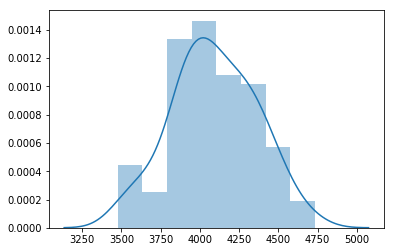

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# estimates.hist(bins=10)

import seaborn as sns
from scipy import stats

sns.distplot(estimates)
print(estimates.describe())